In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import os

import tensorflow as tf
from tensorflow.models.rnn import rnn_cell
from tensorflow.models.rnn import seq2seq

## Synthesize data (circle with noise)

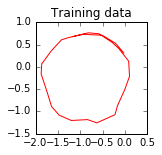

In [2]:
def get_circle_data(nbatches=2500, tsteps = 25, cycle=15):
    N = nbatches*tsteps + 2 #need one extra valus so that we can take differences
    
    #kernel for defining shape of training data (square)
    theta_max = (math.pi*2)*N/cycle
    thetas = np.reshape(np.linspace(0,theta_max,N),(1,N))
    data = np.concatenate((np.cos(thetas), np.sin(thetas)),axis=0)

    data += np.random.uniform(-0.1, 0.1, (2,N))
    data = np.concatenate((data,np.zeros_like(thetas)),axis=0)
    data = data.T
    
    data = data[1:,:] - data[:-1,:]
    
    #convert to 2D vols of data
    X = data[:-1,:]
    X_vol = np.zeros((X.shape[0]/tsteps,tsteps,3))
    for i in range(X.shape[0]/tsteps):
        X_vol[i,:,:] = X[i*tsteps : (i+1)*tsteps,:]
    Y = data[1:,:]
    Y_vol = np.zeros((Y.shape[0]/tsteps,tsteps,3))
    for i in range(Y.shape[0]/tsteps):
        Y_vol[i,:,:] = Y[i*tsteps : (i+1)*tsteps,:]
    return (X_vol, Y_vol)

(X_vol,Y_vol) = get_circle_data(nbatches=100, tsteps=25, cycle=20)

r = Y_vol[0,:,:]
r = np.cumsum(r, axis=0)

plt.figure(figsize=(2,2))
plt.plot(r[:,0], r[:,1],'r-')
plt.title('Training data')

In [3]:
class DataLoader():
    def __init__(self, batch_size=50, tsteps=300, scale_factor = 1, limit = 500):
        self.batch_size = batch_size
        self.tsteps = tsteps
        self.scale_factor = scale_factor
    def next_batch(self):
        (x_batch, y_batch) = get_circle_data(self.batch_size, self.tsteps, cycle=15)
        x_batch[:,:,:2] /= self.scale_factor
        y_batch[:,:,:2] /= self.scale_factor
        return x_batch, y_batch
    def reset_batch_pointer(self):
        return

## Build deep recurrent model with MDN densecap

In [4]:
generate = False
hidden = 128
nlayers = 2
dropout_keep = 0.8
tsteps = 50

batch_size = 100
nmixtures = 20
num_epochs = 30

save_every =50
grad_clip = 10.
learning_rate = 0.01
decay_rate = .95

data_scale=0.1

In [5]:
cell_func = rnn_cell.BasicLSTMCell
cell0 = cell_func(hidden)
cell1 = cell_func(hidden)
# cells = rnn_cell.MultiRNNCell(cell_list)

if (generate == False and dropout_keep < 1): # training mode
    cell0 = rnn_cell.DropoutWrapper(cell0, output_keep_prob = dropout_keep)
    cell1 = rnn_cell.DropoutWrapper(cell1, output_keep_prob = dropout_keep)

input_data = tf.placeholder(dtype=tf.float32, shape=[None, tsteps, 3])
target_data = tf.placeholder(dtype=tf.float32, shape=[None, tsteps, 3])
istate_cell0 = cell0.zero_state(batch_size=batch_size, dtype=tf.float32)
istate_cell1 = cell1.zero_state(batch_size=batch_size, dtype=tf.float32)

In [6]:
n_out = 1 + nmixtures * 6 # end_of_stroke + gaussian mixtures defining stroke locations
#put a mixture density network (mdn) cap on top of the rnn cells
with tf.variable_scope('rnn_root'):
    output_w = tf.get_variable("output_w", [hidden, n_out])
    output_b = tf.get_variable("output_b", [n_out])

#slice the input volume into separate vols for each tstep
inputs = [tf.squeeze(input_, [1]) for input_ in tf.split(1, tsteps, input_data)]

#build cell0 computational graph
outputs, pstate_cell0 = seq2seq.rnn_decoder(inputs, istate_cell0, cell0, loop_function=None, scope='cell0')

#build cell1 computational graph
outputs, pstate_cell1 = seq2seq.rnn_decoder(outputs, istate_cell1, cell1, loop_function=None, scope='cell1')

#put dense cap on top of cell1
output = tf.reshape(tf.concat(1, outputs), [-1, hidden]) #concat outputs before sending them through mdn cap
output = tf.nn.xw_plus_b(output, output_w, output_b) #data flows through mdn

## Add "character window"

In [7]:
# cell_list[0]

A 2D gaussian looks like
$\mathcal{N}(x|\mu,\sigma,\rho)=\frac{1}{2\pi\sigma_1\sigma_2\sqrt(1-\rho^2)}exp\left[\frac{-Z}{2(1-\rho^2)}\right]$ where $Z=\frac{(x_1-\mu_1)^2}{\sigma_1^2}+\frac{(x_2-\mu_2)^2}{\sigma_2^2}-\frac{2\rho(x_1-\mu_1)(x_2-\mu_2)}{\sigma_1\sigma_2}$

In [8]:
def gaussian2d(x1, x2, mu1, mu2, s1, s2, rho):
    # define gaussian mdn (eq 24, 25 from http://arxiv.org/abs/1308.0850)
    x_mu1 = tf.sub(x1, mu1)
    x_mu2 = tf.sub(x2, mu2)
    Z = tf.square(tf.div(x_mu1, s1)) + \
        tf.square(tf.div(x_mu2, s2)) - \
        2*tf.div(tf.mul(rho, tf.mul(x_mu1, x_mu2)), tf.mul(s1, s2))
    rho_square_term = 1-tf.square(rho)
    power_e = tf.exp(tf.div(-Z,2*rho_square_term))
    regularize_term = 2*np.pi*tf.mul(tf.mul(s1, s2), tf.sqrt(rho_square_term))
    gaussian = tf.div(power_e, regularize_term)
    return gaussian

Given the mdn cap, our loss function becomes 
$$ \mathcal{L}(x)=\sum_{t=1}^{T} -log\left(\sum_{j} \pi_t^j\mathcal{N}(x_{t+1}|\mu_t^j,\sigma_t^j,\rho_t^j)
\right)
-\left\{
        \begin{array}{ll}
            \log e_t & (x_{t+1})_3=1\\
            \log(1-e_t) & \quad \mathrm{otherwise}
        \end{array}
    \right.
$$

In [9]:
def get_loss(pi, x1_data, x2_data, eos_data, mu1, mu2, sigma1, sigma2, rho, eos):
    # define loss function (eq 26 of http://arxiv.org/abs/1308.0850)
    gaussian = gaussian2d(x1_data, x2_data, mu1, mu2, sigma1, sigma2, rho)
    term1 = tf.mul(gaussian, pi)
    term1 = tf.reduce_sum(term1, 1, keep_dims=True) #do inner summation
    term1 = -tf.log(tf.maximum(term1, 1e-20)) # some errors are zero -> numerical errors.

    term2 = tf.mul(eos, eos_data) + tf.mul(1-eos, 1-eos_data) #modified Bernoulli -> eos probability
    term2 = -tf.log(term2) #negative log error gives loss
    
    return tf.reduce_sum(term1 + term2) #do outer summation

The gaussian mixture density network parameters are 

$$e_t=\frac{1}{1+\exp(\hat e_t)} \quad \quad \pi_t^j=\frac{\exp(\hat \pi_t^j)}{\sum_{j'=1}^M\exp(\hat \pi_t^{j'})} \quad \quad \mu_t^j=\hat \mu_t^j \quad \quad \sigma_t^j=\exp(\hat \sigma_t^j)  \quad \quad  \rho_t^j=\tanh(\hat \rho_t^j)$$

In [10]:
# below is where we need to do MDN splitting of distribution params
def get_mixture_coef(z):
    # returns the tf slices containing mdn dist params (eq 18...23 of http://arxiv.org/abs/1308.0850)
    z_eos = z[:, 0:1] #end of sentence tokens
    z_pi, z_mu1, z_mu2, z_s1, z_s2, z_rho = tf.split(1, 6, z[:, 1:])
    
    # end of stroke signal
    eos = tf.sigmoid(-1*z_eos) # technically we gained a negative sign

    # softmax z_pi:
    max_pi = tf.reduce_max(z_pi, 1, keep_dims=True)
    z_pi = tf.exp( tf.sub(z_pi, max_pi) )
    normalize_term = tf.inv(tf.reduce_sum(z_pi, 1, keep_dims=True))
    pi = tf.mul(normalize_term, z_pi)
    
    #leave mu1, mu2 as they are
    mu1 = z_mu1; mu2 = z_mu2
    
    # exp for sigmas
    sigma1 = tf.exp(z_s1); sigma2 = tf.exp(z_s2)
    
    #tanh for rho (goes between -1 and 1)
    rho = tf.tanh(z_rho)

    return [eos, pi, mu1, mu2, sigma1, sigma2, rho]

In [11]:
# reshape target data (as we did the input data)
flat_target_data = tf.reshape(target_data,[-1, 3])
[x1_data, x2_data, eos_data] = tf.split(1, 3, flat_target_data) #we might as well split these now

[eos, pi, mu1, mu2, sigma1, sigma2, rho] = get_mixture_coef(output)

loss = get_loss(pi, x1_data, x2_data, eos_data, mu1, mu2, sigma1, sigma2, rho, eos)
cost = loss / (batch_size * tsteps)

## Train model (build graph, then start session)

In [12]:
#define how to train the model
lr = tf.Variable(0.0, trainable=False)
tvars = tf.trainable_variables()
grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars), grad_clip)
optimizer = tf.train.AdamOptimizer(lr)
train_op = optimizer.apply_gradients(zip(grads, tvars))

In [13]:
data_loader = DataLoader(batch_size=batch_size, tsteps=tsteps, scale_factor=data_scale)
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    saver = tf.train.Saver(tf.all_variables())
    for e in xrange(num_epochs):
        sess.run(tf.assign(lr, learning_rate * (decay_rate ** e)))
        data_loader.reset_batch_pointer()
        state0 = istate_cell0.eval()
        state1 = istate_cell1.eval()
        for b in xrange(data_loader.batch_size):
            start = time.time()
            x, y = data_loader.next_batch()
            feed = {input_data: x, target_data: y, istate_cell0: state0, istate_cell1: state1}
            train_loss, state0, state1, _ = sess.run([cost, pstate_cell0, pstate_cell1, train_op], feed)
            end = time.time()
            print "{}/{} (epoch {}), train_loss = {:.3f}, time/batch = {:.3f}" \
                .format(e * data_loader.batch_size + b,
                        num_epochs * data_loader.batch_size,
                        e, train_loss, end - start)
            if (e * data_loader.batch_size + b) % save_every == 0 and ((e * data_loader.batch_size + b) > 0):
                checkpoint_path = os.path.join('saved', 'model.ckpt')
                saver.save(sess, checkpoint_path, global_step = e * data_loader.batch_size + b)
                print "model saved to {}".format(checkpoint_path)

0/3000 (epoch 0), train_loss = 6.600, time/batch = 1.282
1/3000 (epoch 0), train_loss = 5.830, time/batch = 0.686
2/3000 (epoch 0), train_loss = 5.202, time/batch = 0.852
3/3000 (epoch 0), train_loss = 5.082, time/batch = 0.675
4/3000 (epoch 0), train_loss = 4.771, time/batch = 0.631
5/3000 (epoch 0), train_loss = 4.308, time/batch = 0.623
6/3000 (epoch 0), train_loss = 4.046, time/batch = 0.595
7/3000 (epoch 0), train_loss = 3.888, time/batch = 0.610
8/3000 (epoch 0), train_loss = 3.690, time/batch = 0.616
9/3000 (epoch 0), train_loss = 3.539, time/batch = 0.640
10/3000 (epoch 0), train_loss = 3.374, time/batch = 0.755
11/3000 (epoch 0), train_loss = 3.339, time/batch = 0.650
12/3000 (epoch 0), train_loss = 3.191, time/batch = 0.622
13/3000 (epoch 0), train_loss = 3.179, time/batch = 0.587
14/3000 (epoch 0), train_loss = 3.081, time/batch = 0.618
15/3000 (epoch 0), train_loss = 3.085, time/batch = 0.601
16/3000 (epoch 0), train_loss = 3.030, time/batch = 0.616
17/3000 (epoch 0), train

KeyboardInterrupt: 